In [69]:
from keras.layers import Dropout, Dense, Flatten, Activation, Input, Embedding, Dot
from keras.models import Model
from sklearn.model_selection import train_test_split

from pylab import rcParams

import matplotlib.pyplot as plt
import pandas as pd


In [19]:
ratings_df = pd.read_csv('./data/movies/ratings.csv').drop('timestamp', axis=1)
movies_df = pd.read_csv('./data/movies/movies.csv')

In [ ]:
ratings_df.head()

In [20]:
movies_df.head()

In [23]:
users = ratings_df.userId.unique()
movies = ratings_df.movieId.unique()

In [24]:
userid2idx = {o: i for i, o in enumerate(users)}
movieid2idx = {o: i for i, o in enumerate(movies)}
df = ratings_df.copy(deep=True)
df['userId'] = df['userId'].apply(lambda x: userid2idx[x])
df['movieId'] = df['movieId'].apply(lambda x: movieid2idx[x])

In [31]:
df[['userId', 'movieId']]

,userId,movieId
0,0,0
1,0,1
2,0,2
3,0,3
4,0,4
...,...,...
99999,670,7005
100000,670,4771
100001,670,1329
100002,670,1331


In [82]:
train, test = train_test_split(df, test_size=0.20)

In [202]:
n_latent_factors = 64

In [201]:
from keras import ops

def rmse(y_true, y_pred):
    squared_difference = ops.square(y_true - y_pred)
    return ops.sqrt(ops.mean(squared_difference, axis=-1))  # Note the `axis=-1`

Model 1: just embeddings

In [203]:
n_movies = len(df['movieId'].unique())
n_users = len(df['userId'].unique())
user_input = Input(shape=(1,), dtype='int64')
user_embedding = Embedding(n_users, n_latent_factors)(user_input)
user_vec = Flatten(name='FlattenUsers')(user_embedding)

movie_input = Input(shape=(1,), dtype='int64')
movie_embedding = Embedding(n_movies, n_latent_factors)(movie_input)
movie_vec = Flatten(name='FlattenMovies')(movie_embedding)

sim = Dot(axes=1)([user_vec, movie_vec])
emb_model = Model([user_input, movie_input], sim)
emb_model.compile(loss=rmse)

In [204]:
emb_history = emb_model.fit([train.userId, train.movieId], train.rating,
                            validation_data=([test.userId, test.movieId], test.rating),
                            batch_size=64, epochs=15, verbose=1)

Epoch 1/15
1251/1251 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 3.5454 - val_loss: 3.4684
Epoch 2/15
1251/1251 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 3.2670 - val_loss: 2.3182
Epoch 3/15
1251/1251 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 2.0873 - val_loss: 1.6174
Epoch 4/15
1251/1251 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 1.4790 - val_loss: 1.2917
Epoch 5/15
1251/1251 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 1.1818 - val_loss: 1.1344
Epoch 6/15
1251/1251 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 1.0309 - val_loss: 1.0429
Epoch 7/15
1251/1251 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.9301 - val_loss: 0.9831
Epoch 8/15
1251/1251 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.8632 - val_loss: 0.9434
Epoch 9/15
1251/1251 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.8230 - val_loss: 0.9155
Epoch 10/15
1251/1251 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.7799 - val_loss: 0.8958
Epoch 11/15
1251/1251 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.7523 - val_loss: 0.8790
Epoch 12/15
1251/1251 ━━━━━━━━

In [154]:
def plot_loss(_history, saving_path: str = None):
    rcParams['figure.figsize'] = 10, 5
    plt.plot(_history.history['loss'], 'g')
    plt.plot(_history.history['val_loss'], 'b')
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.grid(True)

    if saving_path is not None:
        plt.savefig(saving_path)

    plt.show()


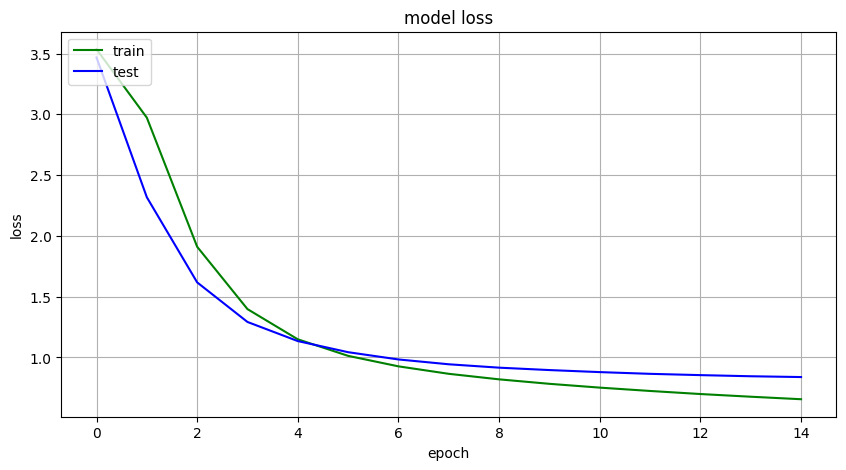

In [205]:
plot_loss(emb_history)

Model 2: NN filtration

In [206]:
from keras.layers import Concatenate, Multiply


n_latent_factors = 50

user_input = Input(shape=(1,), dtype='int64')
user_embedding = Embedding(n_users, n_latent_factors)(user_input)
user_vec = Flatten()(user_embedding)
user_vec = Dropout(0.8)(user_vec)

movie_input = Input(shape=(1,), dtype='int64')
movie_embedding = Embedding(n_movies, n_latent_factors)(movie_input)
movie_vec = Flatten()(movie_embedding)
movie_vec = Dropout(0.8)(movie_vec)

sim = Multiply()([user_vec, movie_vec])

nn_inp = Dense(200, activation='relu')(sim)
nn_inp = Dropout(0.5)(nn_inp)

nn_inp = Dense(1, activation='relu')(nn_inp)

nn_model = Model([user_input, movie_input], nn_inp)
nn_model.compile(loss=rmse)

In [207]:
nn_history = nn_model.fit([trainX.userId, trainX.movieId], train.rating,
                          validation_data=([testX.userId, testX.movieId], test.rating),
                          batch_size=128, epochs=15, verbose=1)

Epoch 1/15
626/626 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 1.6810 - val_loss: 0.8498
Epoch 2/15
626/626 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.8697 - val_loss: 0.8479
Epoch 3/15
626/626 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.8731 - val_loss: 0.8497
Epoch 4/15
626/626 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.8715 - val_loss: 0.8489
Epoch 5/15
626/626 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.8695 - val_loss: 0.8485
Epoch 6/15
626/626 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.8617 - val_loss: 0.8500
Epoch 7/15
626/626 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.8594 - val_loss: 0.8479
Epoch 8/15
626/626 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.8583 - val_loss: 0.8491
Epoch 9/15
626/626 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.8602 - val_loss: 0.8474
Epoch 10/15
626/626 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.8544 - val_loss: 0.8500
Epoch 11/15
626/626 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.8550 - val_loss: 0.8462
Epoch 12/15
626/626 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step

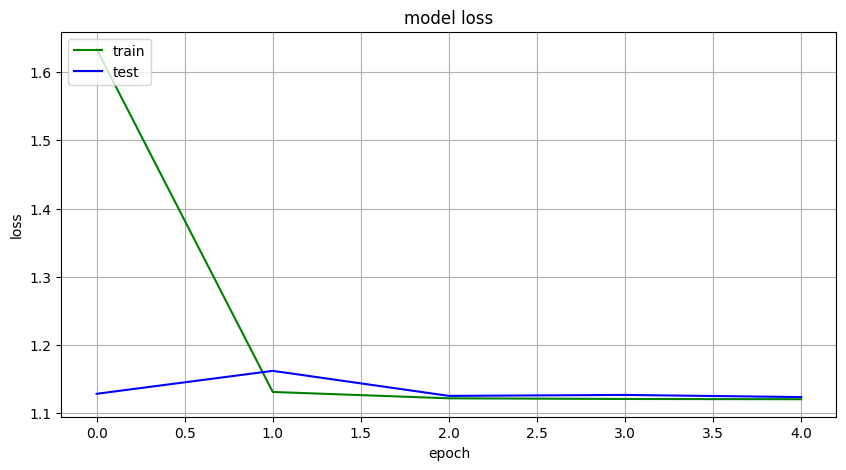

In [144]:
plot_loss(nn_history)